In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from tqdm.auto import tqdm
import tifffile
import matplotlib.pyplot as plt
import random

## Visualising Flows
#### 5-fold data Generated in cellpose format here: https://www.kaggle.com/ks2019/sartorius-train-tif

f0e54d645fe5_img.tif


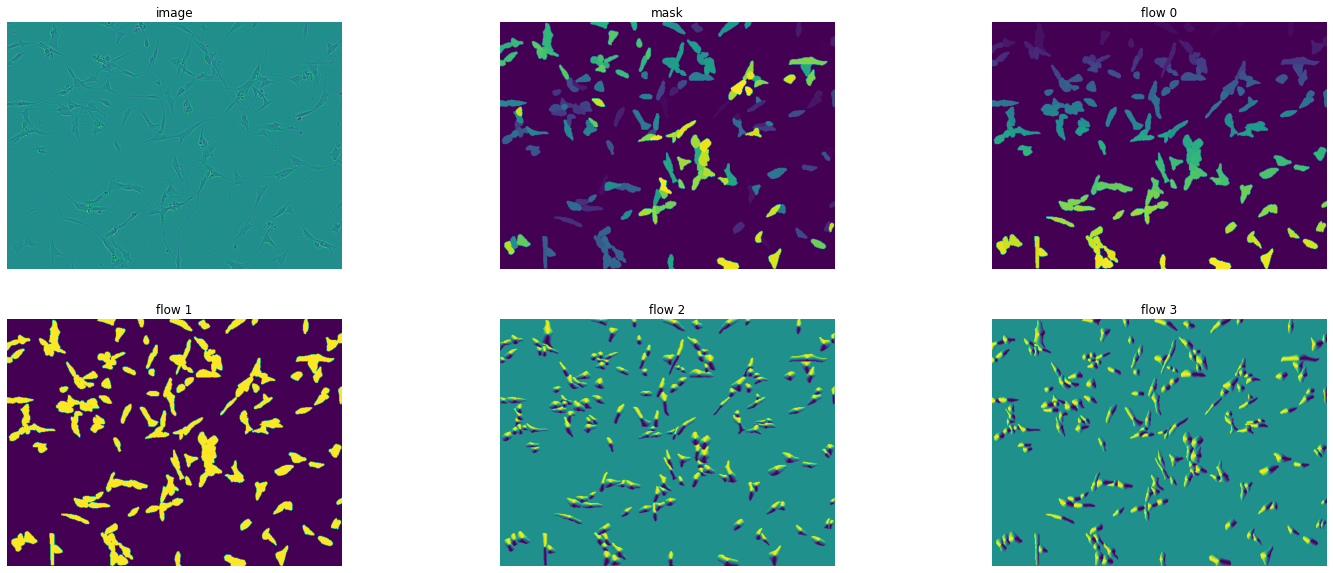

4e99b18bf20f_img.tif


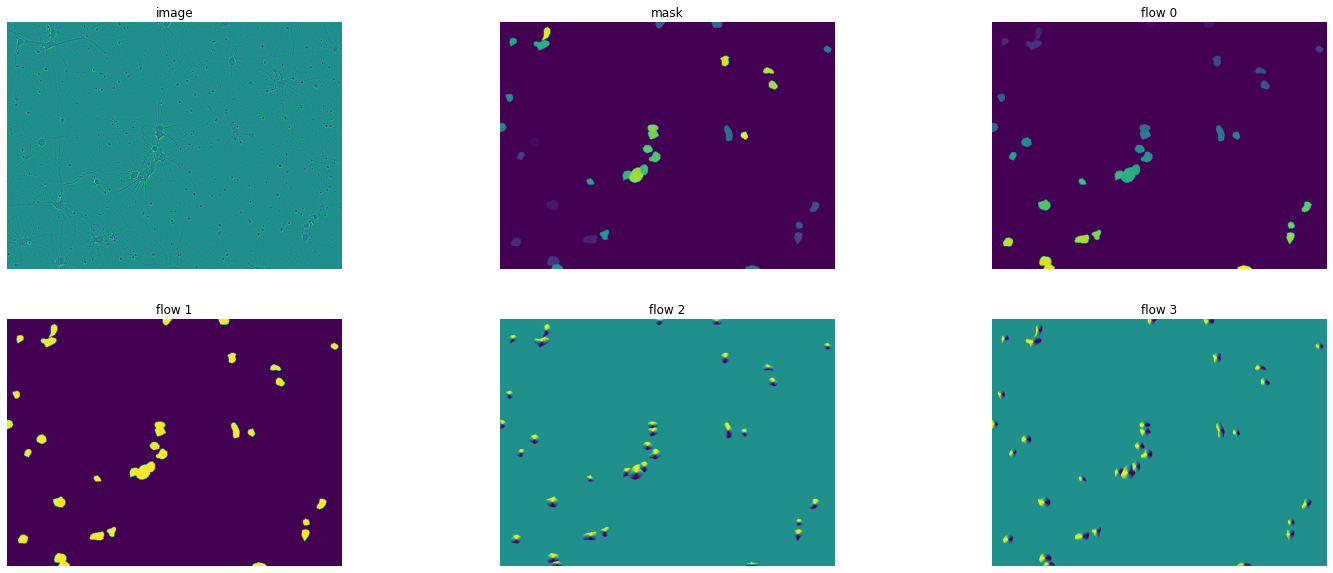

4cf637b37b8b_img.tif


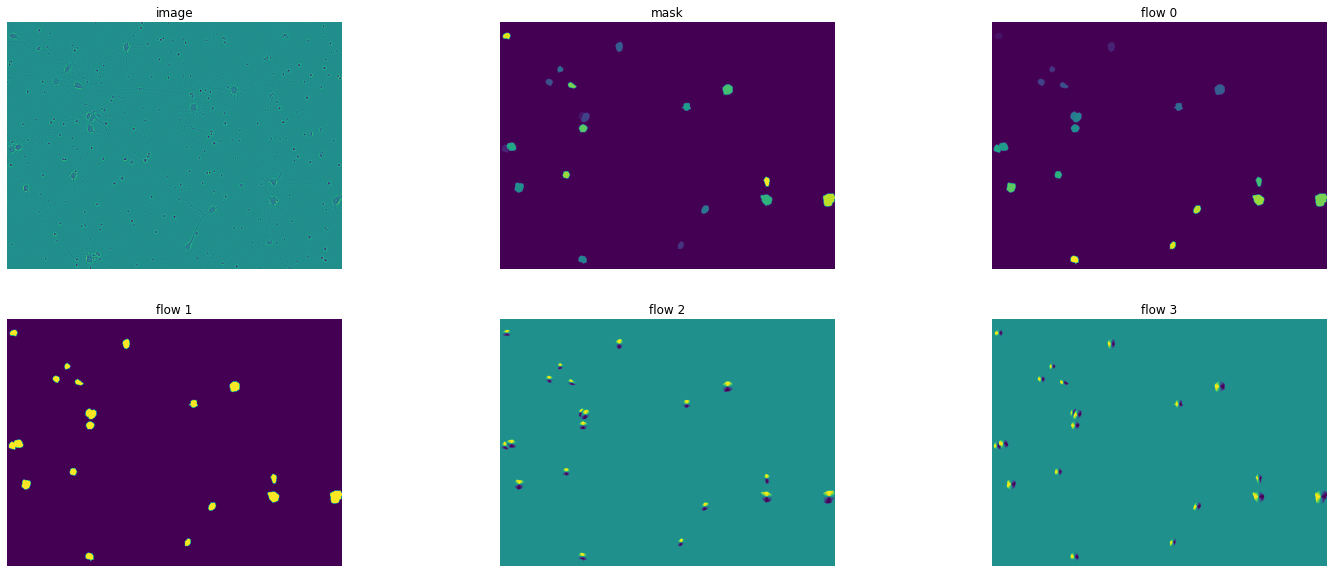

568a4f5d0593_img.tif


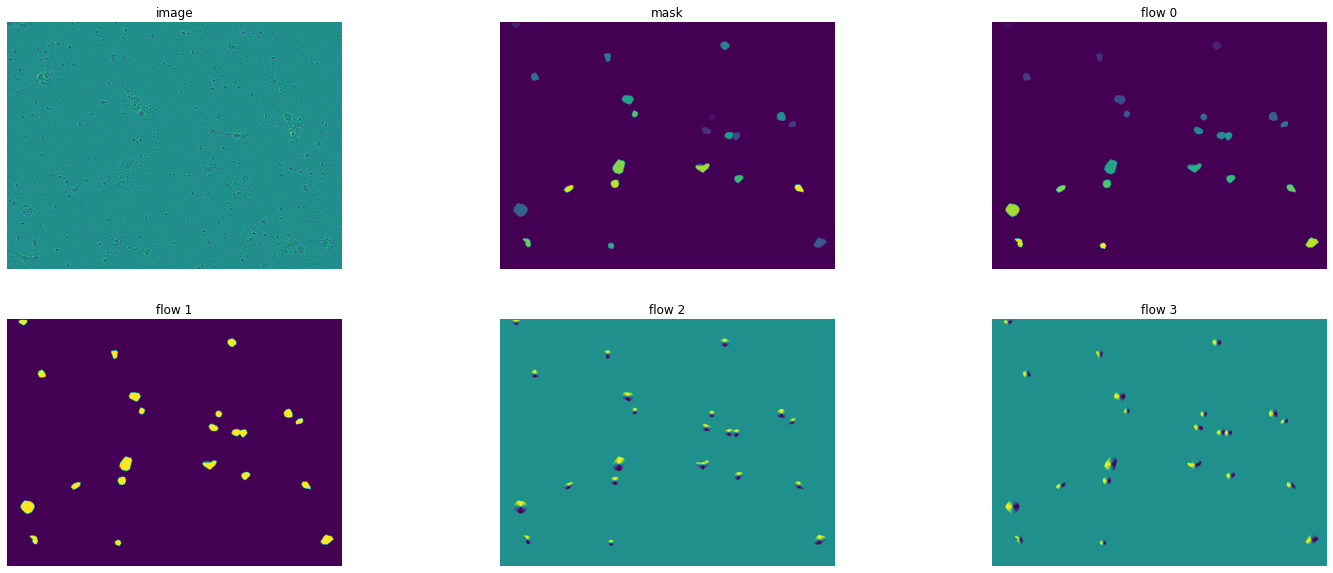

21b1ae35bd39_img.tif


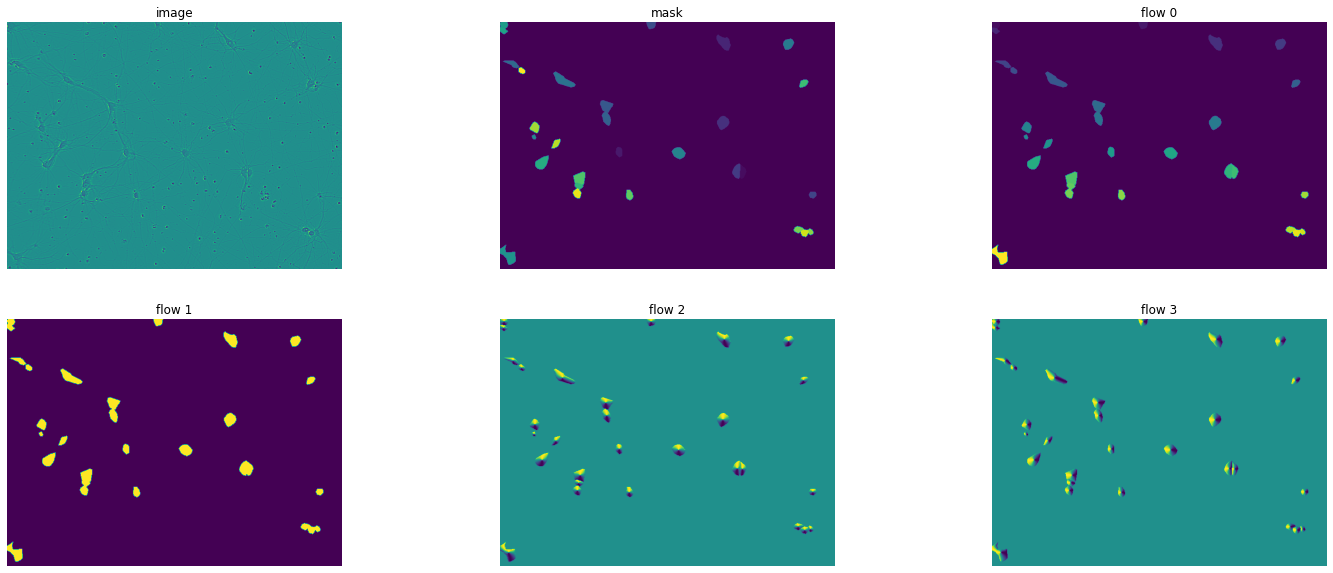

In [2]:
def plot_example(img_path):
    mask_path = img_path.replace('img','masks')
    flow_path = img_path.replace('img','flows')
    img = tifffile.imread(img_path)
    masks = tifffile.imread(mask_path)
    flows = tifffile.imread(flow_path)

    plt.figure(figsize=(25,10))
    plt.subplot(2,3,1)
    plt.axis('off')
    plt.imshow(img)
    plt.title('image')
    plt.subplot(2,3,2)
    plt.axis('off')
    plt.imshow(masks)
    plt.title('mask')
    for k in range(4):
        plt.subplot(2,3,3+k)
        plt.axis('off')
        plt.imshow(flows[k])
        plt.title(f'flow {k}')
    plt.show()
    
root = '../input/sartorius-train-tif/fold_0/train/'
sample_paths = os.listdir(root)
sample_paths = [x for x in sample_paths if 'img' in x]
random.shuffle(sample_paths)
for k in range(5):
    img_path = sample_paths[k]
    print(img_path)
    plot_example(root+img_path)

## Dependencies

In [3]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install -q numpy==1.20.0
!pip install -q cellpose 
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
cudf 21.10.1 requires cupy-cuda110, which is not installed.
beatrix-jupyterlab 3.1.4 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.4.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.4.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.0 which is incompatible.
tfx-bsl 1.4.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.0 which is incompatible.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.0 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompat

## Train

In [4]:
model_to_load = 'cyto2' ## cyto, cyto2, nuclei
number_of_epochs = 1000  ## Train more epochs for better results
batch_size = 8
initial_learning_rate = 0.0002
Training_channel = 0 # For grayscale
Second_training_channel= 0 
train_folder = '/tmp/cellpose_train/train'
test_folder = '/tmp/cellpose_train/val'
FOLD = 2

In [5]:
!mkdir -p /tmp/cellpose_train/

import glob
root = '../input/sartorius-train-tif/'
!cp -r {root}/fold_{FOLD}/* /tmp/cellpose_train/

In [6]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

1455
363


In [7]:
!python -m cellpose --train --use_gpu --fast_mode \
        --dir "$train_folder" --test_dir "$test_folder" \
        --pretrained_model $model_to_load \
        --chan $Training_channel --chan2 $Second_training_channel \
        --n_epochs $number_of_epochs \
        --learning_rate $initial_learning_rate \
        --batch_size $batch_size \
        --img_filter img \
        --mask_filter masks

creating new log file
100%|██████████████████████████████████████| 25.3M/25.3M [00:00<00:00, 49.0MB/s]
Not all flows are present. Run flow generation again.
Not all flows are present. Run flow generation again.
100%|█████████████████████████████████████████| 121/121 [01:23<00:00,  1.45it/s]


In [8]:
!ls -lh /tmp/cellpose_train/train/models

total 26M
-rw-r--r-- 1 root root 26M Dec 26 16:05 cellpose_residual_on_style_on_concatenation_off_train_2021_12_26_12_17_07.246861


In [9]:
!cp -r /tmp/cellpose_train/train/models .

## Inference 

Refer: https://www.kaggle.com/slawekbiel/cellpose-inference-307-lb

In [10]:
model_path = glob.glob('models/*')[0]
print(model_path)

models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_26_12_17_07.246861


In [11]:
%%writefile predict.py
import sys
import numpy as np
from cellpose import models, io, plot
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import glob

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_files = glob.glob('/tmp/cellpose_train/val/*_img.tif')
print(len(test_files))
model = models.CellposeModel(gpu=True, pretrained_model=sys.argv[1])

ids, masks = [],[]
for fn in tqdm(test_files):
    id_ = fn.split('/')[-1].replace('_img.tif','')
    preds, flows, _ = model.eval(io.imread(fn), diameter=19, channels=[0,0], augment=True, resample=True)
    for i in range (1, preds.max() + 1):
        ids.append(id_)
        masks.append(rle_encode(preds == i))
        
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('val_predictions.csv', index=False)

Writing predict.py


In [12]:
!python predict.py {model_path} /tmp/cellpose_train/val

121
100%|█████████████████████████████████████████| 121/121 [02:59<00:00,  1.48s/it]


## Plot

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import skimage
import skimage.segmentation
import matplotlib.pyplot as plt

In [14]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

In [15]:
width = 704
height = 520
shape = [height,width]

train_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

cellpose_predictions = pd.read_csv('val_predictions.csv')
cellpose_predictions = cellpose_predictions.groupby('id').predicted.agg(list).reset_index()
df = pd.merge(train_df,cellpose_predictions,on='id')

print(df.shape)

df.sample(2)

(121, 3)


,id,annotation,predicted
98,d248e894403c,[56957 3 57659 6 58362 8 59066 9 59769 11 6047...,[21171 1 21872 6 22573 10 23276 12 23979 13 24...
51,73c45accba88,[241688 4 242389 9 243092 11 243794 13 244497 ...,[3513 4 4216 5 4919 7 5621 9 6324 10 7027 11 7...


029e5b3b89c7


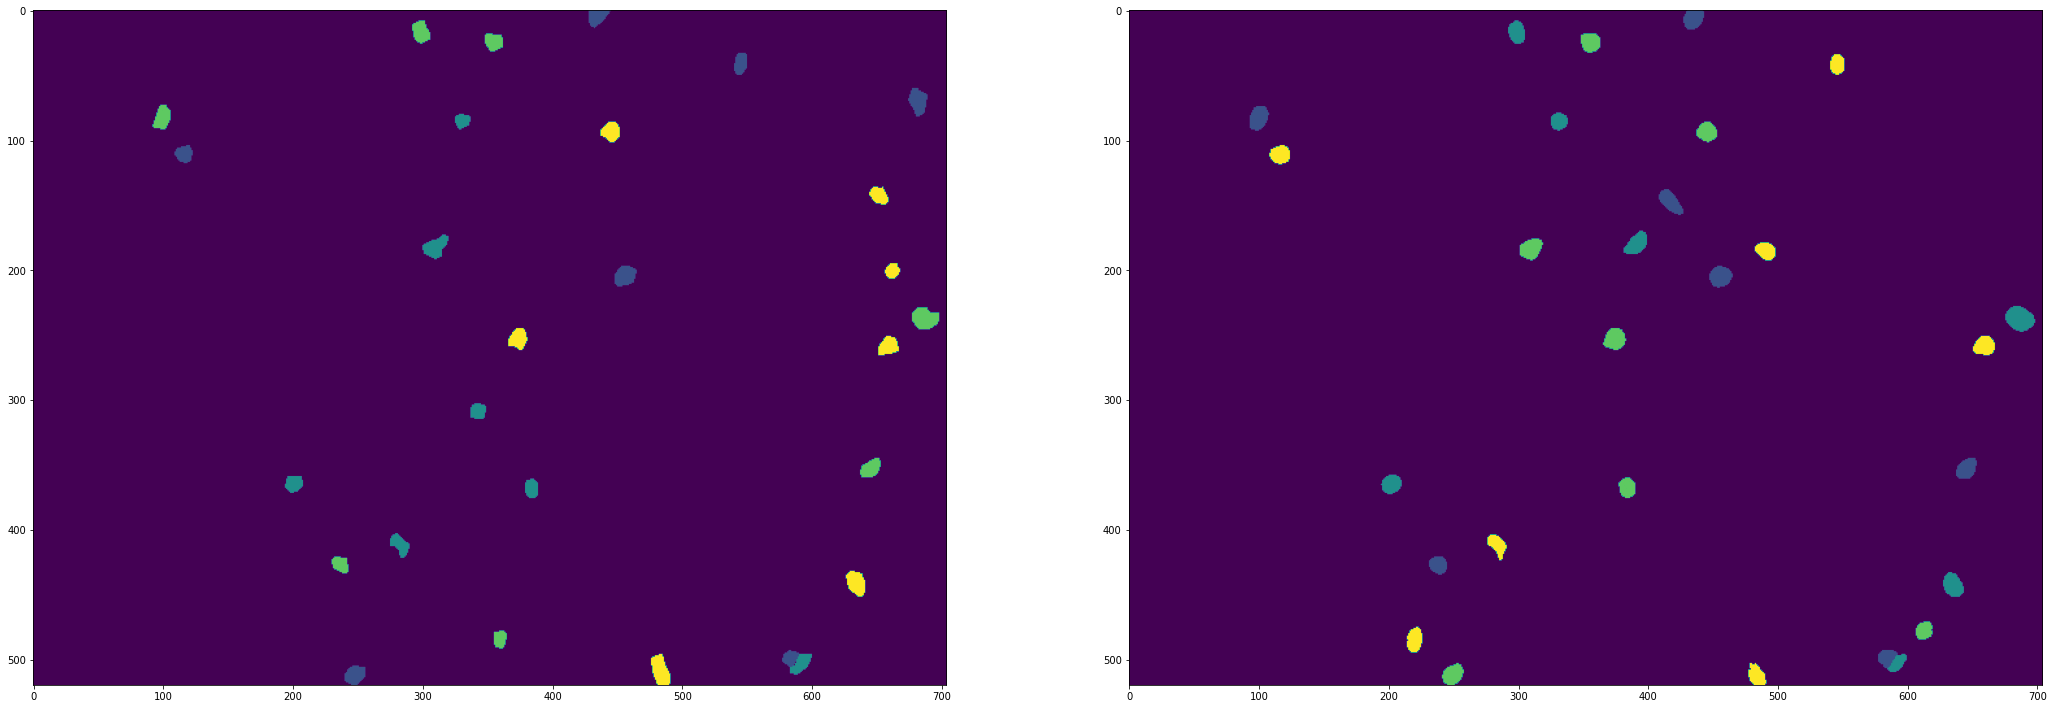

0323e81d23d9


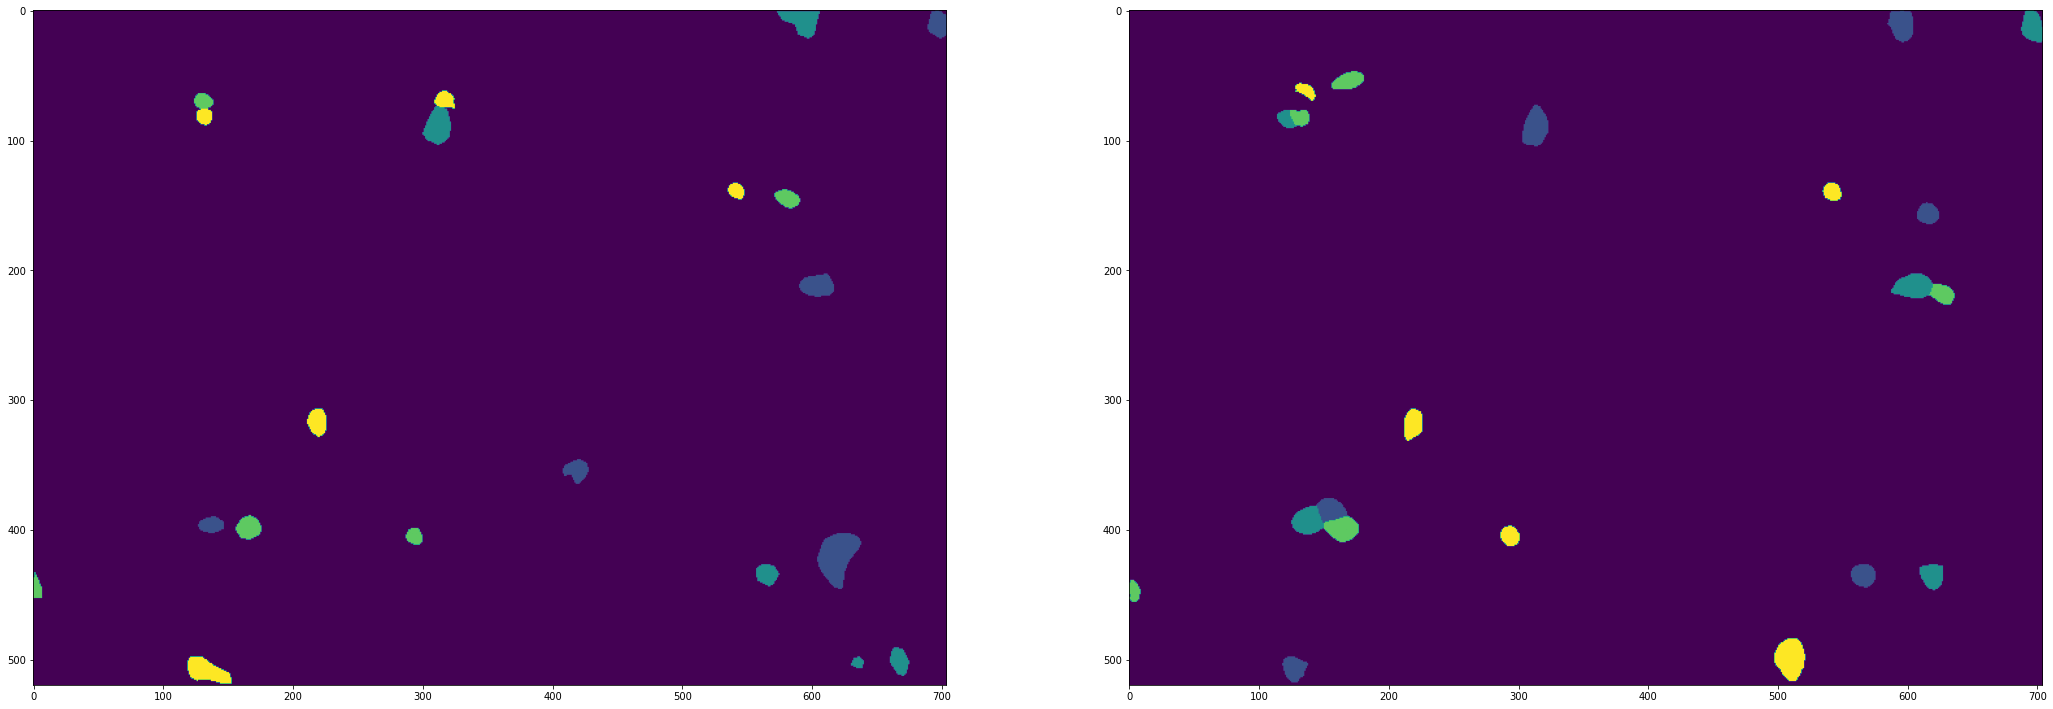

049f02e0f764


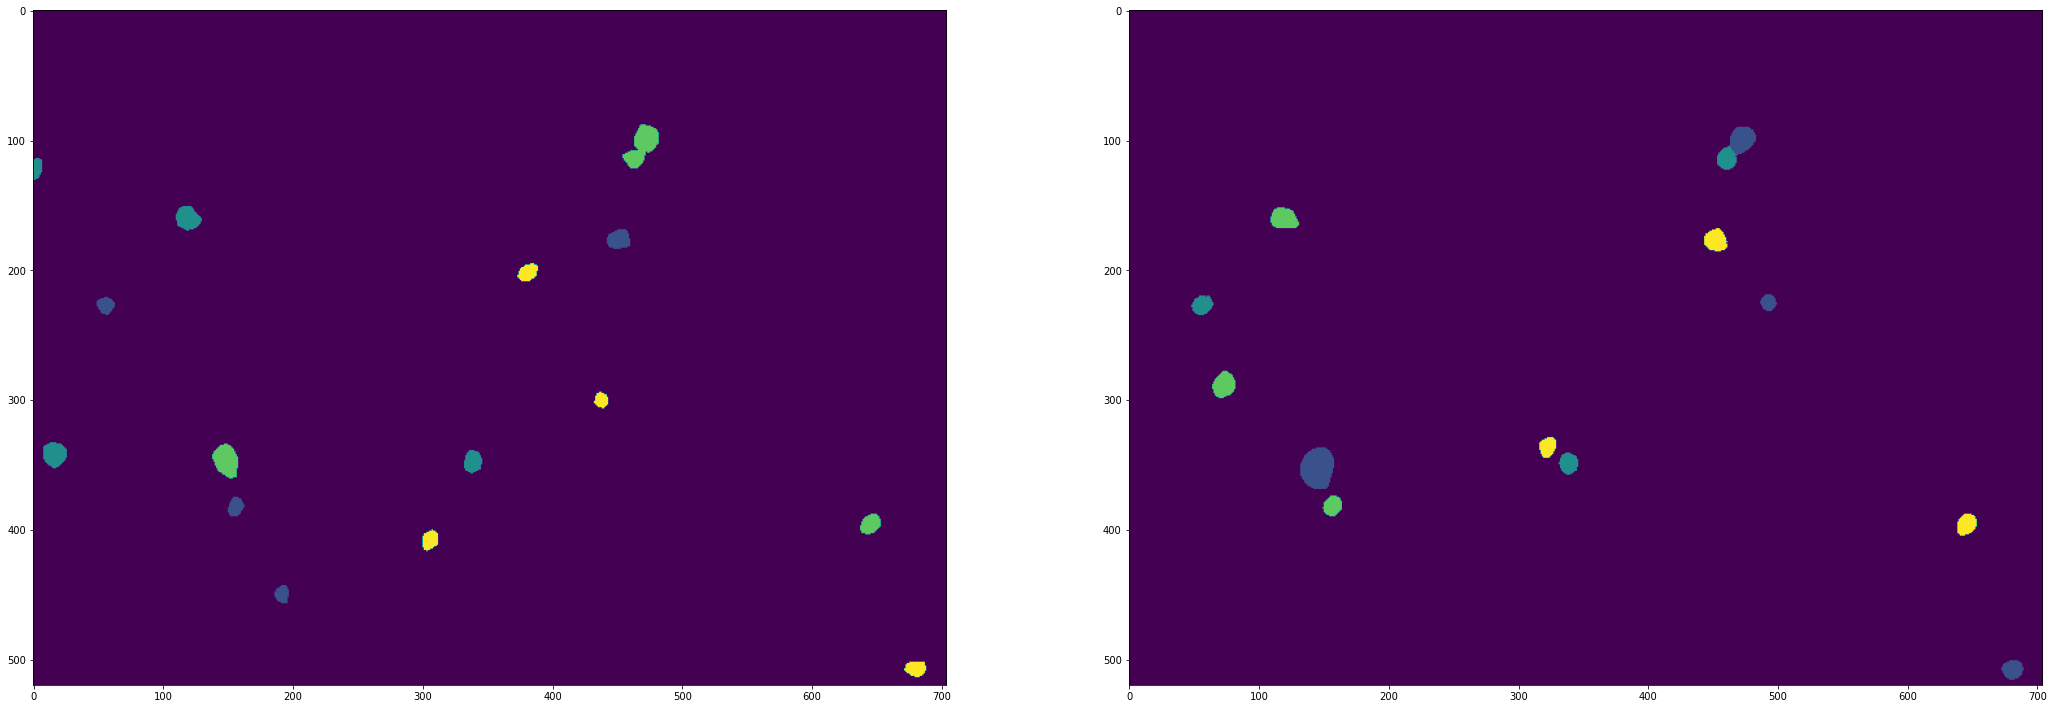

0728b8f39241


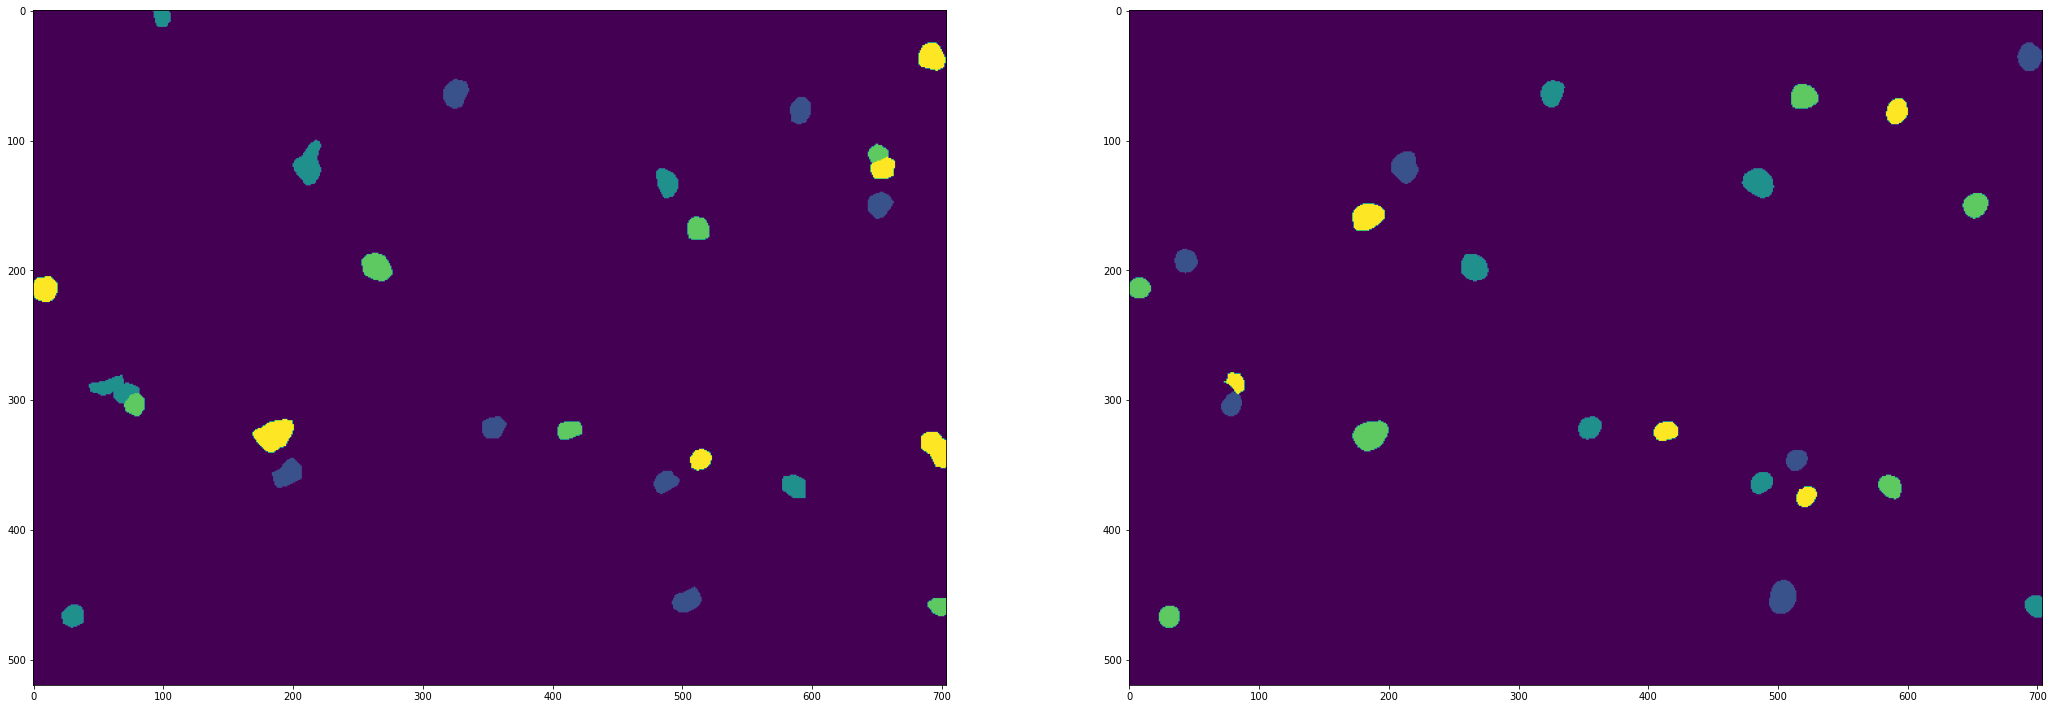

0a6ecc5fe78a


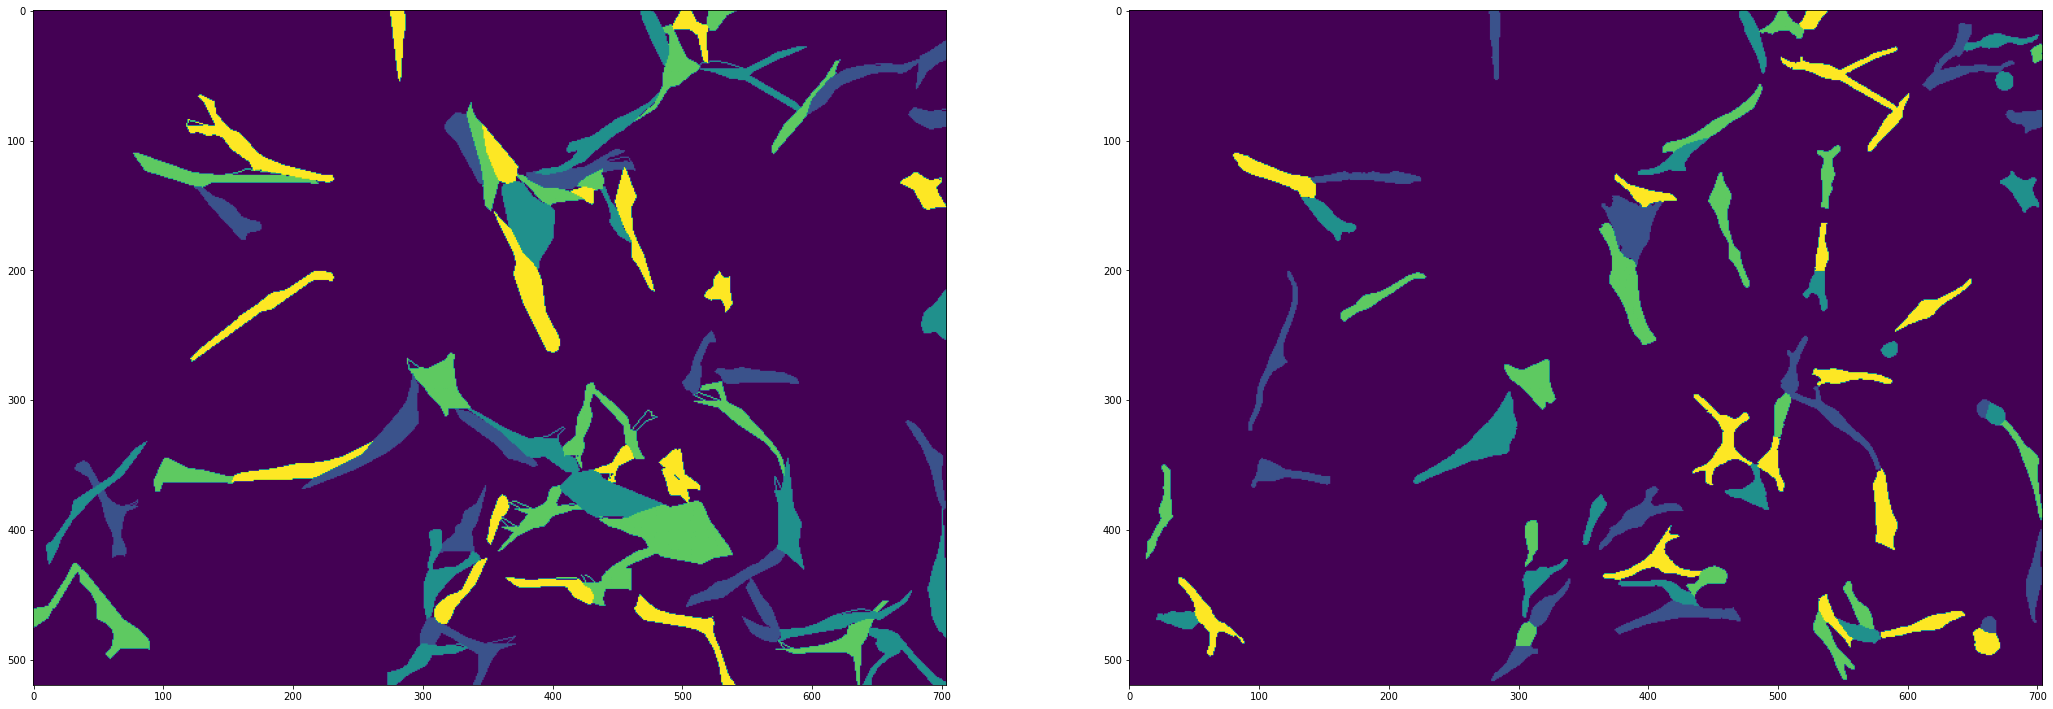

In [16]:
for i,row in df.iterrows():
    
    print(row.id)
    gt_masks = rles_to_mask(row.annotation, shape).astype(np.uint16)
    predicted_masks = rles_to_mask(row.predicted, shape).astype(np.uint16)
    
    gt_masks = (gt_masks>0).astype(int)*(gt_masks%5)
    predicted_masks = (predicted_masks>0).astype(int)*(predicted_masks%5)

    _, axs = plt.subplots(1, 2, figsize=(36, 18))
    axs = axs.flatten()
    axs[0].imshow(gt_masks)
    axs[1].imshow(predicted_masks)
    plt.show()
    
    if i==4: break

## Evaluate

In [17]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [
        compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape)) 
            for truth, pred in tqdm(zip(truths, preds))
    ]
    
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [18]:
annotations = df.annotation.values
predictions = df.predicted.values

In [19]:
iou_map(annotations,predictions,verbose=1)

0it [00:00, ?it/s]

(34, 34)
Thresh	TP	FP	FN	Prec.
0.500	5997	1402	8630	0.374
0.550	5623	1776	9004	0.343
0.600	5155	2244	9472	0.306
0.650	4556	2843	10071	0.261
0.700	3775	3624	10852	0.207
0.750	2726	4673	11901	0.141
0.800	1556	5843	13071	0.076
0.850	601	6798	14026	0.028
0.900	78	7321	14549	0.004
0.950	2	7397	14625	0.000
AP	-	-	-	0.174


0.17390725516927222